In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'

# Merton's (1976) Jump Diffusion Model

## Numerical Integration Method

In [55]:
%%time
from scipy.integrate import quad
#
# Model Parameters
#
S0 = 100.0 # initial index level
K = 100.0 # strike level
T = 1.0 # call option maturity
r = 0.05 # constant short rate
sigma = 0.4 # constant volatility of diffusion
lamb = 1.0 # jump frequency p.a.
mu = -0.2 # expected jump size
delta = 0.1 # jump size volatility
#
# Valuation by Integration
#
def M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Lewis (2001) Fourier-based approach.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    strike price
    T: float
    time-to-maturity (for t=0)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    lamb: float
    jump intensity
    mu: float
    expected jump size
    delta: float
    standard deviation of jump
    Returns
    =======
    call_value: float
    European call option present value
    '''
    int_value = quad(lambda u: M76_integration_function_INT(u, S0, K, T, r,
    sigma, lamb, mu, delta), 0, 50, limit=250)[0]
    call_value = S0 - np.exp(-r * T) * math.sqrt(S0 * K) / math.pi * int_value
    return call_value
def M76_integration_function_INT(u, S0, K, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Lewis (2001) Fourier-based approach: integration function.
    Parameter definitions see function M76_value_call_INT. '''
    JDCF = M76_characteristic_function_INT(u - 0.5 * 1j, T, r,
    sigma, lamb, mu, delta)
    value = 1 / (u ** 2 + 0.25) * (np.exp(1j * u * math.log(S0 / K))
    * JDCF).real
    return value
def M76_characteristic_function_INT(u, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Lewis (2001) Fourier-based approach: characteristic function.
    Parameter definitions see function M76_value_call_INT. '''
    omega = r - 0.5 * sigma ** 2 - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 +
    lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return value

print("Value of Call Option %8.3f" % M76_value_call_INT(S0, K, T, r, sigma, lamb, mu, delta))

Value of Call Option   19.948
CPU times: total: 0 ns
Wall time: 1.99 ms


## Fast Fourier Transform (FFT)

In [56]:
%%time
from numpy.fft import *
#
# Model Parameters
#
S0 = 100.0 # initial index level
K = 100.0 # strike level
T = 1.0 # call option maturity
r = 0.05 # constant short rate
sigma = 0.4 # constant volatility of diffusion
lamb = 1.0 # jump frequency p.a.
mu = -0.2 # expected jump size
delta = 0.1 # jump size volatility
#
# M76 Characteristic Function
#
def M76_characteristic_function_FFT(u, x0, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Lewis (2001) Fourier-based approach: characteristic function.
    Parameter definitions see function M76_value_call_FFT. '''
    omega = x0 / T + r - 0.5 * sigma ** 2 \
    - lamb * (np.exp(mu + 0.5 * delta ** 2) - 1)
    value = np.exp((1j * u * omega - 0.5 * u ** 2 * sigma ** 2 +
    lamb * (np.exp(1j * u * mu - u ** 2 * delta ** 2 * 0.5) - 1)) * T)
    return value
#
# Valuation by FFT
#
def M76_value_call_FFT(S0, K, T, r, sigma, lamb, mu, delta):
    ''' Valuation of European call option in M76 model via
    Carr-Madan (1999) Fourier-based approach.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    strike price
    T: float
    time-to-maturity (for t=0)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    lamb: float
    jump intensity
    mu: float
    expected jump size
    delta: float
    standard deviation of jump
    Returns
    =======
    call_value: float
    European call option present value
    '''
    k = math.log(K / S0)
    x0 = math.log(S0 / S0)
    g = 2 # factor to increase accuracy
    N = g * 4096
    eps = (g * 150.) ** -1
    eta = 2 * math.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)
    # Modificatons to Ensure Integrability
    if S0 >= 0.95 * K: # ITM case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        mod_char_fun = math.exp(-r * T) * M76_characteristic_function_FFT(
        v, x0, T, r, sigma, lamb, mu, delta) \
        / (alpha ** 2 + alpha - vo ** 2 + 1j * (2 * alpha + 1) * vo)
    else: # OTM case
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        mod_char_fun_1 = math.exp(-r * T) * (1 / (1 + 1j * (vo - 1j * alpha))
        - math.exp(r * T) / (1j * (vo - 1j * alpha))
        - M76_characteristic_function(
        v, x0, T, r, sigma, lamb, mu, delta)
        / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha)))
        v = (vo + 1j * alpha) - 1j
        mod_char_fun_2 = math.exp(-r * T) * (1 / (1 + 1j * (vo + 1j * alpha))
        - math.exp(r * T) / (1j * (vo + 1j * alpha))
        - M76_characteristic_function(
        v, x0, T, r, sigma, lamb, mu, delta)
        / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha)))

    # Numerical FFT Routine
    delt = np.zeros(N, dtype=np.float64)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        fft_func = np.exp(1j * b * vo) * mod_char_fun * eta * SimpsonW
        payoff = (fft(fft_func)).real
        call_value_m = np.exp(-alpha * k) / math.pi * payoff
    else:
        fft_func = (np.exp(1j * b * vo)
        * (mod_char_fun_1 - mod_char_fun_2)
        * 0.5 * eta * SimpsonW)
        payoff = (fft(fft_func)).real
        call_value_m = payoff / (np.sinh(alpha * k) * math.pi)
    pos = int((k + b) / eps)
    call_value = call_value_m[pos]
    return call_value * S0

print("Value of Call Option %8.3f" % M76_value_call_FFT(S0, K, T, r, sigma, lamb, mu, delta))

Value of Call Option   19.948
CPU times: total: 15.6 ms
Wall time: 3 ms


# Calibration of Merton's (1976)

## To Three Maturities

In [13]:
import pandas as pd
import scipy.optimize as sop
np.set_printoptions(suppress=True,
formatter={'all': lambda x: '%5.3f' % x})

In [17]:
data = pd.HDFStore('option_data.h5', 'r')['data']# European call & put option data (3 maturities)
data.head()

,Date,Strike,Call,Maturity,Put
0,1412035200000000000,1850.0,1373.6,1418947200000000000,0.5
1,1412035200000000000,1900.0,1323.7,1418947200000000000,0.6
2,1412035200000000000,1950.0,1273.8,1418947200000000000,0.8
3,1412035200000000000,2000.0,1223.9,1418947200000000000,0.9
4,1412035200000000000,2050.0,1174.1,1418947200000000000,1.1


In [18]:
S0 = 3225.93 # EURO STOXX 50 level
r = 0.0005 # ECB base rate
# Option Selection
tol = 0.02
options = data[(np.abs(data['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]
options['Date'] = pd.DatetimeIndex(options['Date'])
options['Maturity'] = pd.DatetimeIndex(options['Maturity'])
options.head()

,Date,Strike,Call,Maturity,Put
456,2014-09-30,3175.0,82.3,2014-10-17,24.5
457,2014-09-30,3200.0,64.3,2014-10-17,31.5
458,2014-09-30,3225.0,48.3,2014-10-17,40.5
459,2014-09-30,3250.0,34.6,2014-10-17,51.8
460,2014-09-30,3275.0,23.5,2014-10-17,65.8


In [32]:
def M76_error_function_FFT(p0):
    ''' Error Function for parameter calibration in M76 Model via
    Carr-Madan (1999) FFT approach.

    Parameters
    ==========
    sigma: float
        volatility factor in diffusion term
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    RMSE: float
        root mean squared error
    '''
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_value_call_FFT(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Call']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE


def generate_plot(opt, options):
    #
    # Calculating Model Prices
    #
    sigma, lamb, mu, delta = opt
    options['Model'] = 0.0
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options.loc[row, 'Model'] = M76_value_call_FFT(S0, option['Strike'],
                                            T, r, sigma, lamb, mu, delta)

    #
    # Plotting
    #
    mats = sorted(set(options['Maturity']))
    options = options.set_index('Strike')
    for i, mat in enumerate(mats):
        options[options['Maturity'] == mat][['Call', 'Model']].\
            plot(style=['b-', 'ro'], title='%s' % str(mat)[:10],
                 grid=True)
        plt.ylabel('option value')

In [33]:
# Calibration

i = 0 # counter initialization
min_RMSE = 100 # minimal RMSE initialization
p0 = sop.brute(M76_error_function_FFT, ((0.075, 0.201, 0.025),
                (0.10, 0.401, 0.1), (-0.5, 0.01, 0.1),
                (0.10, 0.301, 0.1)), finish=None)
# p0 = [0.15, 0.2, -0.3, 0.2]
opt = sop.fmin(M76_error_function_FFT, p0,
                maxiter=500, maxfun=750,
                xtol=0.000001, ftol=0.000001)

   0 | [0.075 0.100 -0.500 0.100] |  54.754 |  54.754
  50 | [0.075 0.300 -0.100 0.300] |  54.754 |  54.754
 100 | [0.100 0.200 -0.200 0.200] |  54.754 |  54.754
 150 | [0.125 0.100 -0.300 0.100] |  54.754 |  54.754
 200 | [0.125 0.400 -0.500 0.300] |  54.754 |  54.754
 250 | [0.150 0.200 0.000 0.200] |  54.754 |  54.754
 300 | [0.175 0.100 -0.100 0.100] |  54.754 |  54.754
 350 | [0.175 0.400 -0.300 0.300] |  54.754 |  54.754
 400 | [0.200 0.300 -0.400 0.200] |  54.754 |  54.754
 450 | [0.062 0.399 -0.001 0.443] |  54.754 |  54.754
 500 | [0.002 0.490 -0.012 1.589] |  48.756 |  21.624
 550 | [0.002 0.490 -0.012 1.631] |  20.410 |  20.317
 600 | [0.002 0.491 -0.012 1.630] |  20.311 |  20.311
 650 | [0.001 0.498 -0.012 1.629] |  20.311 |  20.311
 700 | [0.000 0.508 -0.013 1.626] |  20.311 |  20.311
 750 | [0.000 0.509 -0.013 1.626] |  20.311 |  20.311
 800 | [0.000 0.510 -0.013 1.625] |  20.311 |  20.311
 850 | [0.000 0.519 -0.013 1.623] |  20.311 |  20.311
 900 | [0.000 0.539 -0.013 1.

C:\Users\harki\AppData\Local\Temp\ipykernel_8848\2968050765.py:9: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  opt = sop.fmin(M76_error_function_FFT, p0,


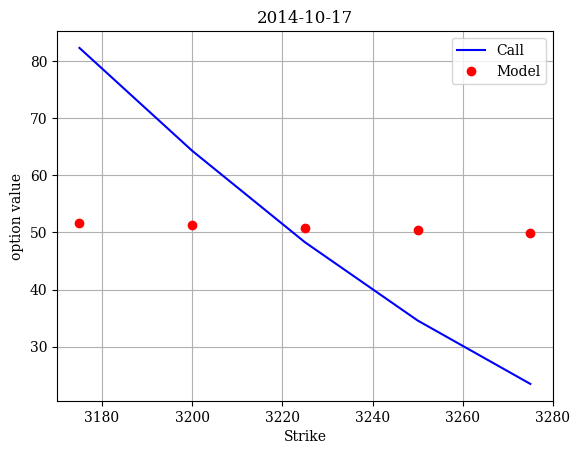

In [34]:
generate_plot(opt, options)

## To Short Maturity

In [35]:
S0 = 3225.93  # EURO STOXX 50 level
r = 0.005  # assumption

# Option Selection
tol = 0.05
options = data[(np.abs(data['Strike'] - S0) / S0) < tol]
mats = sorted(set(options['Maturity']))
options = options[options['Maturity'] == mats[0]]
options['Date'] = pd.DatetimeIndex(options['Date'])
options['Maturity'] = pd.DatetimeIndex(options['Maturity'])
options.head()

,Date,Strike,Call,Maturity,Put
452,2014-09-30,3075.0,167.0,2014-10-17,9.3
453,2014-09-30,3100.0,144.5,2014-10-17,11.7
454,2014-09-30,3125.0,122.7,2014-10-17,14.9
455,2014-09-30,3150.0,101.8,2014-10-17,19.1
456,2014-09-30,3175.0,82.3,2014-10-17,24.5


In [36]:
def M76_error_function_FFT(p0):
    ''' Error function for parameter calibration in M76 Model via
    Carr-Madan (1999) FFT approach.

    Parameters
    ==========
    sigma: float
        volatility factor in diffusion term
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump

    Returns
    =======
    RMSE: float
        root mean squared error
    '''
    global i, min_RMSE
    sigma, lamb, mu, delta = p0
    if sigma < 0.0 or delta < 0.0 or lamb < 0.0:
        return 500.0
    se = []
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        model_value = M76_value_call_FFT(S0, option['Strike'], T,
                                         r, sigma, lamb, mu, delta)
        se.append((model_value - option['Call']) ** 2)
    RMSE = math.sqrt(sum(se) / len(se))
    min_RMSE = min(min_RMSE, RMSE)
    if i % 50 == 0:
        print('%4d |' % i, np.array(p0), '| %7.3f | %7.3f' % (RMSE, min_RMSE))
    i += 1
    return RMSE

# Graphical Output
def generate_plot(opt, options):
    #
    # Calculating Model Prices
    #
    sigma, lamb, mu, delta = opt
    options['Model'] = 0.0
    for row, option in options.iterrows():
        T = (option['Maturity'] - option['Date']).days / 365.
        options.loc[row, 'Model'] = M76_value_call_FFT(S0, option['Strike'],
                                    T, r, sigma, lamb, mu, delta)

    #
    # Plotting
    #
    options = options.set_index('Strike')
    fig, ax = plt.subplots(2, sharex=True, figsize=(8, 7))
    options[['Call', 'Model']].plot(style=['b-', 'ro'],
                    title='%s' % str(option['Maturity'])[:10], ax=ax[0])
    ax[0].set_ylabel('option values')
    ax[0].grid(True)
    xv = options.index.values
    ax[1] = plt.bar(xv - 5 / 2., options['Model'] - options['Call'],
                    width=5)
    plt.ylabel('difference')
    plt.xlim(min(xv) - 10, max(xv) + 10)
    plt.tight_layout()
    plt.grid(True)


In [37]:
i = 0
min_RMSE = 100.
p0 = sop.brute(M76_error_function_FFT, ((0.10, 0.201, 0.025),
                (0.1, 0.8, 0.1), (-0.4, 0.01, 0.1),
                (0.00, 0.121, 0.02)), finish=None)

opt = sop.fmin(M76_error_function_FFT, p0, xtol=0.00001,
                ftol=0.00001, maxiter=750, maxfun=1500)

   0 | [0.100 0.100 -0.400 0.000] |  13.102 |  13.102
  50 | [0.100 0.200 -0.200 0.020] |  13.076 |  10.498
 100 | [0.100 0.300 0.000 0.040] |  15.439 |   7.988
 150 | [0.100 0.500 -0.300 0.060] |   6.113 |   4.338
 200 | [0.100 0.600 -0.100 0.080] |  11.885 |   4.338
 250 | [0.125 0.100 -0.400 0.100] |   9.130 |   4.014
 300 | [0.125 0.200 -0.200 0.120] |   9.114 |   4.014
 350 | [0.125 0.400 -0.400 0.000] |   1.560 |   1.560
 400 | [0.125 0.500 -0.200 0.020] |   5.130 |   1.560
 450 | [0.125 0.600 0.000 0.040] |  11.243 |   1.352
 500 | [0.150 0.100 -0.300 0.060] |   6.054 |   1.352
 550 | [0.150 0.200 -0.100 0.080] |   6.796 |   1.352
 600 | [0.150 0.400 -0.400 0.100] |   3.825 |   1.352
 650 | [0.150 0.500 -0.200 0.120] |   2.761 |   1.352
 700 | [0.150 0.700 -0.400 0.000] |  11.710 |   1.352
 750 | [0.175 0.100 -0.200 0.020] |   5.392 |   1.352
 800 | [0.175 0.200 0.000 0.040] |   5.842 |   1.352
 850 | [0.175 0.400 -0.300 0.060] |   7.138 |   1.352
 900 | [0.175 0.500 -0.100 0.08

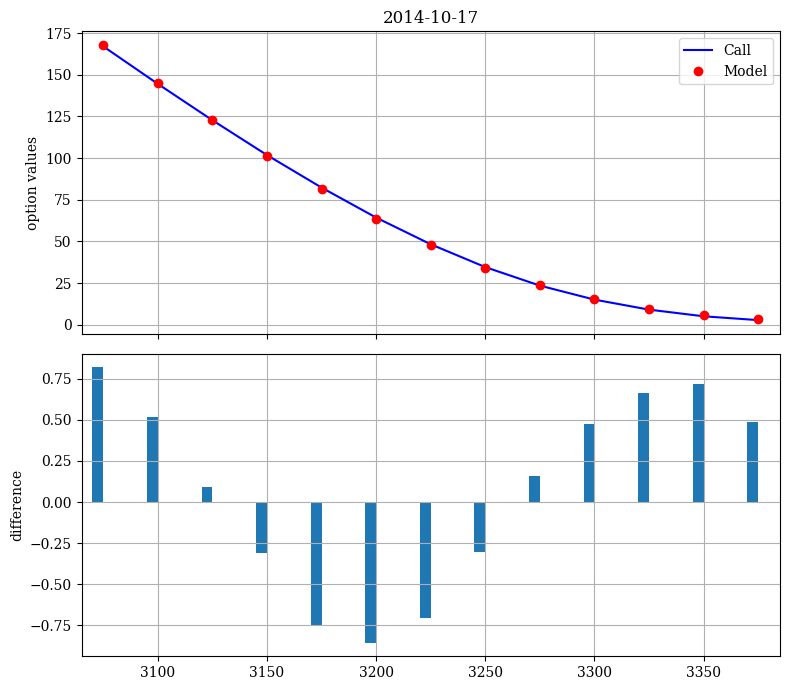

In [38]:
generate_plot(opt, options)

# Monte Carlo Simulation

In [57]:
# Model Parameters (from Calibration)
#
S0 = 3225.93 # EURO STOXX 50 level (30.09.2014)
T = 0.22 # shortest maturity
r = 0.005 # assumption
sigma, lamb, mu, delta = [0.113, 3.559, -0.075, 0.041]
# from calibration
#
# Valuation by Simulation
#
seed = 100000 # seed value
M = 50 # time steps
I = 200000 # paths
disc = 2 # 1 = simple Euler; else = log Euler
def M76_generate_paths(S0, T, r, sigma, lamb, mu, delta, M, I):
    ''' Generate Monte Carlo Paths for M76 Model.
    Parameters
    ==========
    S0: float
    initial stock/index level
    K: float
    strike price
    T: float
    time-to-maturity (for t=0)
    r: float
    constant risk-free short rate
    sigma: float
    volatility factor in diffusion term
    lamb: float
    jump intensity
    mu: float
    expected jump size
    delta: float
    standard deviation of jump
    M: int
    number of time intervals
    I: int
    number of paths
    Returns
    =======
    S: array
    simulated paths
    '''
    dt = T / M
    rj = lamb * (math.exp(mu + 0.5 * delta ** 2) - 1)
    shape = (M + 1, I)
    S = np.zeros((M + 1, I), dtype=np.float64)
    S[0] = S0
    np.random.seed(10000)
    rand1 = np.random.standard_normal(shape)
    rand2 = np.random.standard_normal(shape)
    rand3 = np.random.poisson(lamb * dt, shape)
    for t in range(1, M + 1, 1):
        if disc == 1:
            S[t] = S[t - 1] * ((1 + (r - rj) * dt) + sigma
                    * math.sqrt(dt) * rand1[t]
                    + (np.exp(mu + delta * rand2[t]) - 1)
                    * rand3[t])
        else:
            S[t] = S[t - 1] * (np.exp((r - rj - 0.5 * sigma ** 2) * dt
                    + sigma * math.sqrt(dt) * rand1[t])
                    + (np.exp(mu + delta * rand2[t]) - 1)
                    * rand3[t])
    return S

def M76_value_call_MCS(K):
    ''' Function to calculate the MCS estimator given K.
    Parameters
    ==========
    K: float
    strike price
    Returns
    =======
    call_mcs: float
    European call option Monte Carlo estimator
    '''
    return math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I



In [58]:
 # Single Valuation
S = M76_generate_paths(S0, T, r, sigma, lamb, mu, delta, M, I)
print("Value of Call Option %8.3f" % M76_value_call_MCS(S0))

# Value Comparisons
strikes = np.arange(3000, 3601, 50)
values = np.zeros((3, len(strikes)), dtype=np.float64)
z = 0
for k in strikes:
    print("CALL STRIKE       %10.3f" % k)
    print("----------------------------")
    values[0, z] = M76_value_call_INT(S0, k, T, r, sigma,
                                      lamb, mu, delta)
    print("Call Value by Int %10.3f" % values[0, z])

    values[1, z] = M76_value_call_FFT(S0, k, T, r, sigma,
                                      lamb, mu, delta)
    print("Call Value by FFT %10.3f" % values[1, z])
    print("Difference FFT/Int%10.3f" % (values[1, z] - values[0, z]))
    values[2, z] = M76_value_call_MCS(k)
    print("Call Value by MCS %10.3f" % values[2, z])
    print("Difference MCS/Int%10.3f" % (values[2, z] - values[0, z]))
    print("----------------------------")
    z = z + 1

results = pd.DataFrame(values.T, index=strikes, columns=['INT', 'FFT', 'MCS'])
results.index.name = 'Strike'

Value of Call Option  116.609
CALL STRIKE         3000.000
----------------------------
Call Value by Int    269.749
Call Value by FFT    269.733
Difference FFT/Int    -0.016
Call Value by MCS    270.503
Difference MCS/Int     0.754
----------------------------
CALL STRIKE         3050.000
----------------------------
Call Value by Int    231.142
Call Value by FFT    231.118
Difference FFT/Int    -0.025
Call Value by MCS    231.827
Difference MCS/Int     0.685
----------------------------
CALL STRIKE         3100.000
----------------------------
Call Value by Int    194.905
Call Value by FFT    194.890
Difference FFT/Int    -0.015
Call Value by MCS    195.531
Difference MCS/Int     0.625
----------------------------
CALL STRIKE         3150.000
----------------------------
Call Value by Int    161.340
Call Value by FFT    161.346
Difference FFT/Int     0.006
Call Value by MCS    161.905
Difference MCS/Int     0.565
----------------------------
CALL STRIKE         3200.000
-------------

TypeError: M76_characteristic_function() takes 7 positional arguments but 8 were given